In [3]:
import os
from PIL import Image

source_directory = 'CIFAR-10-images/test'
target_directory = 'data'

if not os.path.exists(target_directory):
    os.makedirs(target_directory)

for folder_name in os.listdir(source_directory):
    folder_path = os.path.join(source_directory, folder_name)
    target_folder = os.path.join(target_directory, folder_name)

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            source_path = os.path.join(folder_path, filename)
            target_path = os.path.join(target_folder, filename)
            image = Image.open(source_path)
            grayscale_image = image.convert('L')
            grayscale_image.save(target_path)

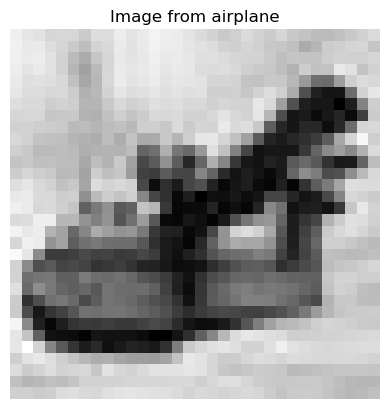

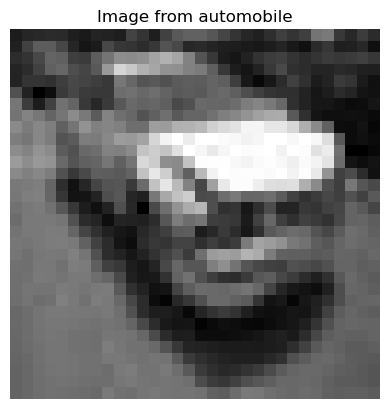

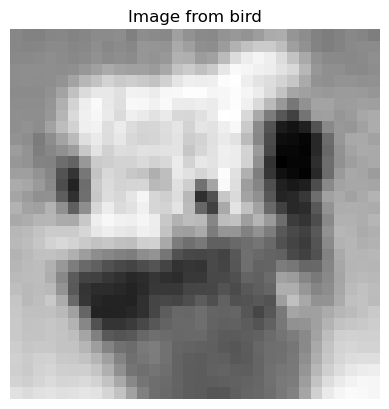

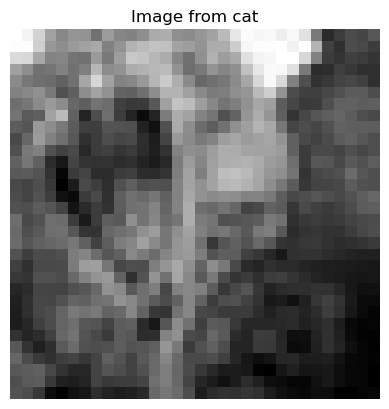

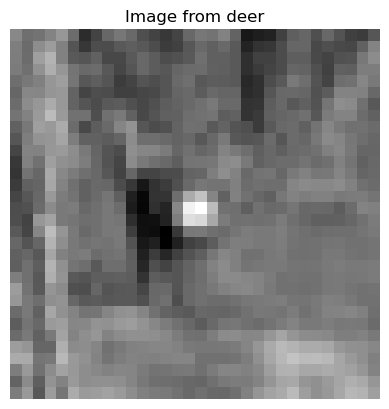

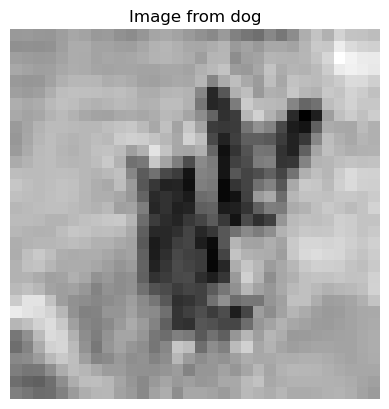

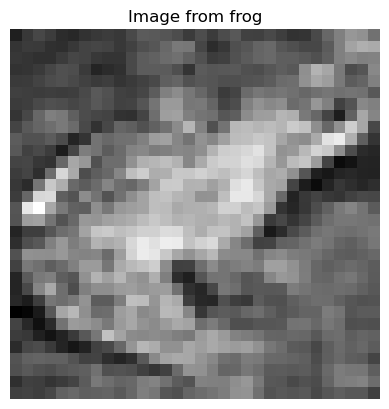

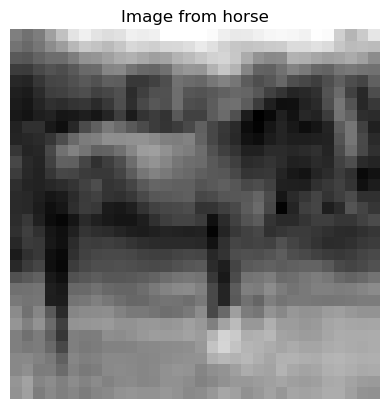

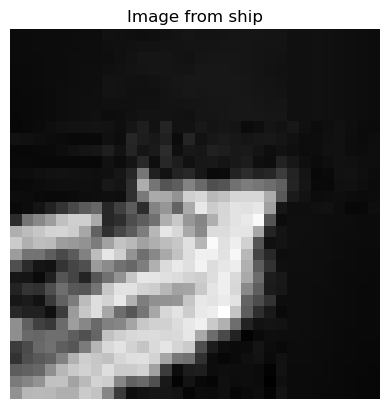

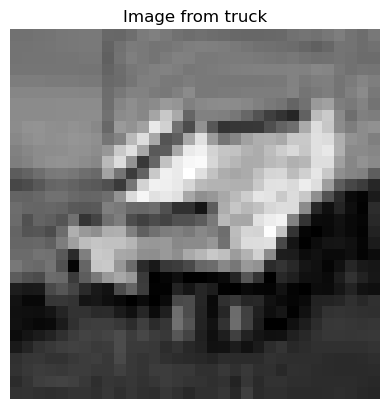

In [4]:
import random
import matplotlib.pyplot as plt

input_directory = 'data'

subfolders = [subdir for subdir in os.listdir(input_directory) if os.path.isdir(os.path.join(input_directory, subdir))]

for subfolder in subfolders:
    subfolder_path = os.path.join(input_directory, subfolder)
    image_files = [file for file in os.listdir(subfolder_path) if file.endswith(".jpg")]

    if image_files:
        random_image_file = random.choice(image_files)
        image_path = os.path.join(subfolder_path, random_image_file)

        image = Image.open(image_path)
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.title(f"Image from {subfolder}")
        plt.axis('off')

plt.show()

In [6]:
import numpy as np
import cv2
from tqdm import tqdm

In [7]:
TRAINING_DIRECTORY = 'CIFAR-10-images/test'
CATEGORIES_LIST = os.listdir(TRAINING_DIRECTORY)
print(CATEGORIES_LIST)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
TRAINING_DATA = []
for category in CATEGORIES_LIST:
    path = os.path.join(TRAINING_DIRECTORY, category)
    class_number = CATEGORIES_LIST.index(category)
    for image_file in tqdm(os.listdir(path)):
        image_array = cv2.imread(os.path.join(path, image_file), cv2.IMREAD_GRAYSCALE)
        TRAINING_DATA.append([image_array, class_number])

# Shuffle training data
random.shuffle(TRAINING_DATA)

100%|██████████| 1000/1000 [00:00<00:00, 7345.12it/s]


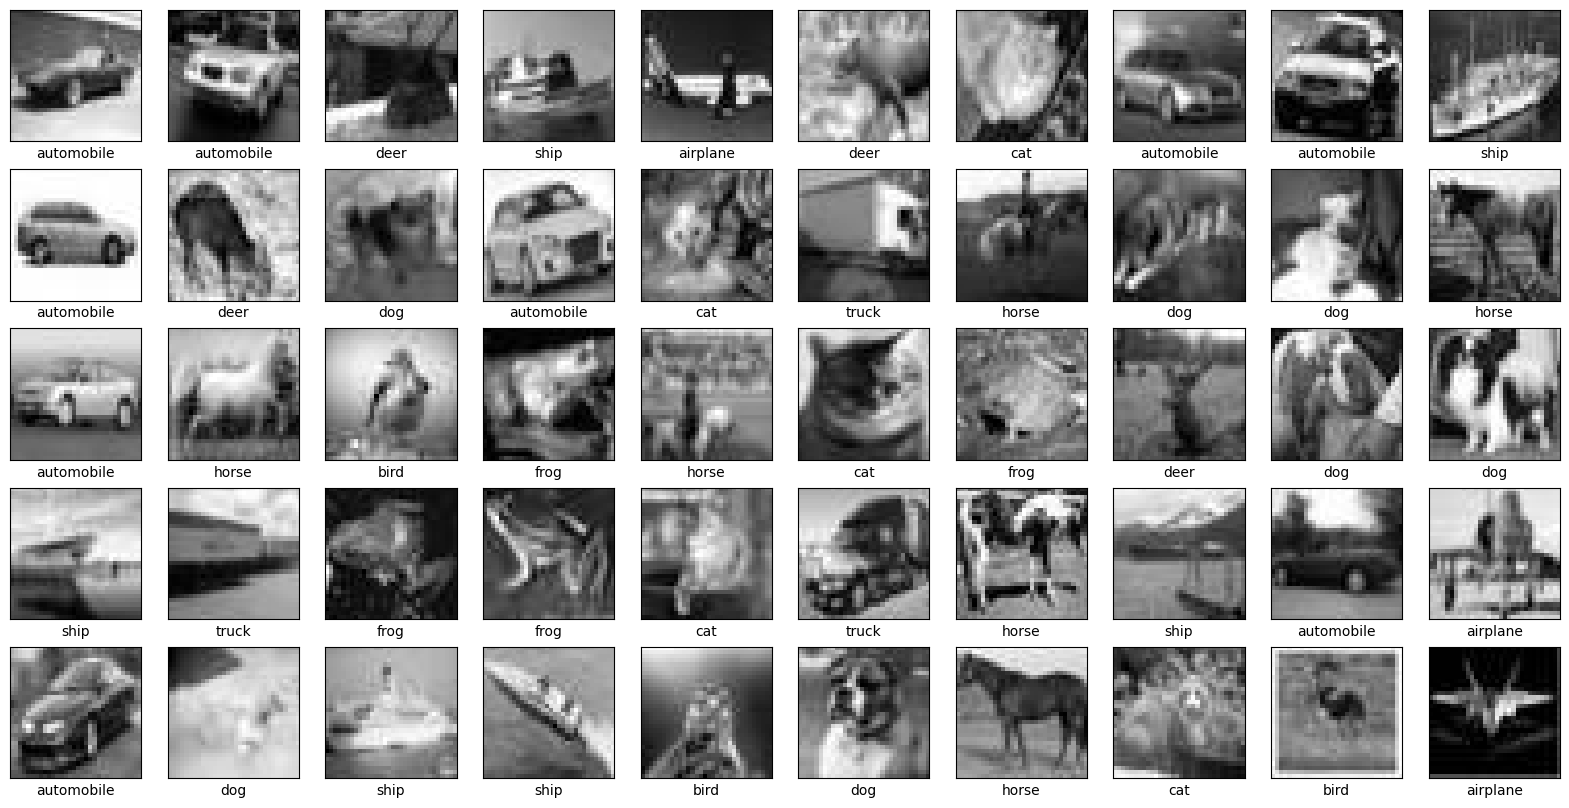

In [9]:
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(TRAINING_DATA[i][0], cmap='gray')
    plt.xlabel(CATEGORIES_LIST[TRAINING_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49:
        break
plt.show()

In [10]:
fold_size = 10
folds = [TRAINING_DATA[i:i+fold_size] for i in range(0, len(TRAINING_DATA), fold_size)]

In [11]:
def plot_accuracies(fold_num, k_values, accuracy_data):
    best_result = [0, 0]
    for k in k_values:
        accuracy_values = accuracy_data[k]
        if best_result[1] < max(accuracy_values):
            best_result[0] = k
            best_result[1] = max(accuracy_values)
        plt.scatter([k] * len(accuracy_values), accuracy_values)

    accuracies_mean = np.array([np.mean(values) for key, values in sorted(accuracy_data.items())])
    accuracies_std = np.array([np.std(values) for key, values in sorted(accuracy_data.items())])
    plt.errorbar(k_values, accuracies_mean, yerr=accuracies_std)
    plt.title(f"Cross-validation   fold={fold_num}   K={best_result[0]}   Accuracy = {best_result[1]}")
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()

In [12]:
k_values = [1, 3, 5, 7, 9]
k_values_error_l1 = {k: [] for k in k_values}
k_values_error_l2 = {k: [] for k in k_values}

In [13]:
for i in range(5):
    # Define training and validation sets
    training_set = [fold for j, fold in enumerate(folds) if j != i]
    validation_set = folds[i]

    l1_accuracies = []
    l2_accuracies = []

    for k in k_values:
        l1_correct = 0
        l2_correct = 0
        total = 0

        for validation_data in tqdm(validation_set):
            v_img = validation_data[0]
            v_label = validation_data[1]
            l1_scores = []
            l2_scores = []

            for fold in training_set:
                for training_data in fold:
                    t_img = training_data[0]
                    t_label = training_data[1]

                    l1_dist = np.sum(np.abs(t_img - v_img))
                    l1_scores.append((l1_dist, t_label))

                    l2_dist = np.sqrt(np.sum((t_img - v_img) ** 2))
                    l2_scores.append((l2_dist, t_label))

            sorted_l1_scores = sorted(l1_scores, key=lambda x: x[0])[:k]
            l1_neighbors = [s[1] for s in sorted_l1_scores]
            l1_prediction = max(set(l1_neighbors), key=l1_neighbors.count)

            sorted_l2_scores = sorted(l2_scores, key=lambda x: x[0])[:k]
            l2_neighbors = [s[1] for s in sorted_l2_scores]
            l2_prediction = max(set(l2_neighbors), key=l2_neighbors.count)

            if l1_prediction == v_label:
                l1_correct += 1
            if l2_prediction == v_label:
                l2_correct += 1
            total += 1

        l1_accuracy = l1_correct / total
        l1_accuracies.append(l1_accuracy)
        k_values_error_l1[k].append(l1_accuracy)

        l2_accuracy = l2_correct / total
        l2_accuracies.append(l2_accuracy)
        k_values_error_l2[k].append(l2_accuracy)

        print("Fold {}, k = {}, L1 accuracy = {:.2f}%, L2 accuracy = {:.2f}%".format(i, k, l1_accuracy * 100, l2_accuracy * 100))

    min_l1_accuracy = min(l1_accuracies)
    max_l1_accuracy = max(l1_accuracies)
    midpoint_l1_accuracy = (min_l1_accuracy + max_l1_accuracy) / 2

    min_l2_accuracy = min(l2_accuracies)
    max_l2_accuracy = max(l2_accuracies)
    midpoint_l2_accuracy = (min_l2_accuracy + max_l2_accuracy) / 2

100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


Fold 0, k = 1, L1 accuracy = 50.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


Fold 0, k = 3, L1 accuracy = 30.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Fold 0, k = 5, L1 accuracy = 20.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Fold 0, k = 7, L1 accuracy = 20.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Fold 0, k = 9, L1 accuracy = 20.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


Fold 1, k = 1, L1 accuracy = 0.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Fold 1, k = 3, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Fold 1, k = 5, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


Fold 1, k = 7, L1 accuracy = 30.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Fold 1, k = 9, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Fold 2, k = 1, L1 accuracy = 0.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Fold 2, k = 3, L1 accuracy = 0.00%, L2 accuracy = 0.00%


100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


Fold 2, k = 5, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Fold 2, k = 7, L1 accuracy = 20.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Fold 2, k = 9, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Fold 3, k = 1, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Fold 3, k = 3, L1 accuracy = 30.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Fold 3, k = 5, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Fold 3, k = 7, L1 accuracy = 20.00%, L2 accuracy = 10.00%


100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Fold 3, k = 9, L1 accuracy = 20.00%, L2 accuracy = 20.00%


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Fold 4, k = 1, L1 accuracy = 20.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Fold 4, k = 3, L1 accuracy = 0.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


Fold 4, k = 5, L1 accuracy = 10.00%, L2 accuracy = 30.00%


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Fold 4, k = 7, L1 accuracy = 0.00%, L2 accuracy = 40.00%


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

Fold 4, k = 9, L1 accuracy = 0.00%, L2 accuracy = 40.00%


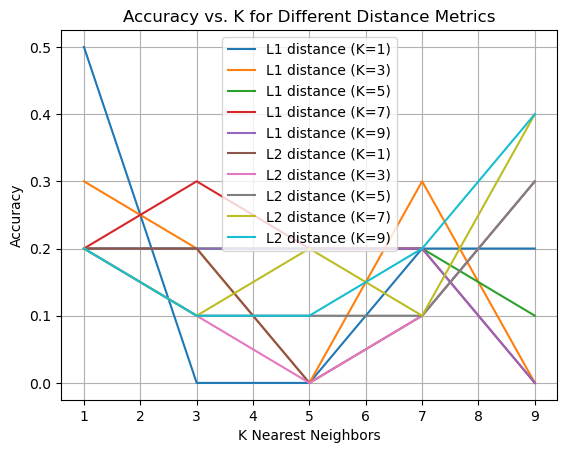

In [14]:
plt.plot(k_values, k_values_error_l1[1], label='L1 distance (K=1)')
plt.plot(k_values, k_values_error_l1[3], label='L1 distance (K=3)')
plt.plot(k_values, k_values_error_l1[5], label='L1 distance (K=5)')
plt.plot(k_values, k_values_error_l1[7], label='L1 distance (K=7)')
plt.plot(k_values, k_values_error_l1[9], label='L1 distance (K=9)')

plt.plot(k_values, k_values_error_l2[1], label='L2 distance (K=1)')
plt.plot(k_values, k_values_error_l2[3], label='L2 distance (K=3)')
plt.plot(k_values, k_values_error_l2[5], label='L2 distance (K=5)')
plt.plot(k_values, k_values_error_l2[7], label='L2 distance (K=7)')
plt.plot(k_values, k_values_error_l2[9], label='L2 distance (K=9)')

plt.xlabel('K Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K for Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()